In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

In [2]:
data_dir='../../Enzyme_Constraints/kcat_adjustment_and_enzyme_allocation_predictions/out'

with open(os.path.join(data_dir,"rho_sweep.pkl"),'rb') as file:
    regularisation_sweep_data=pickle.load(file)

results={'enzyme_allocation':pd.read_csv(os.path.join(data_dir,'enzyme_predictions_adjusted_vs_unadjusted.csv'),index_col=0),
         'scalings':pd.read_csv(os.path.join(data_dir,'fitted_sigmas.csv'),index_col=0),
        'kcats':pd.read_csv(os.path.join(data_dir,'adjusted_kcats.csv'),index_col=0),
        'regularisation_coefficient_sweep':regularisation_sweep_data}

def RMSEL(x,y,treat_zeros_as=0.):
    x[x==0]=treat_zeros_as
    y[y==0]=treat_zeros_as
    SEL=0.
    count=0
    for i in range(x.shape[0]):
        if x[i]>0 and y[i]>0:
            SEL+=(np.log10(x[i])-np.log10(y[i]))**2
            count+=1
    return np.sqrt(SEL/count)
def geometric_mean(x):
    x_nonzero=x[x>0]
    return np.exp(np.log(x_nonzero).mean())


In [3]:
#Parameters
label_fs=12
title_fs=12

# Enzyme Allocation predictions with original kcats

In [4]:
carbon_sources_bigg2name_map={'glc__D_e':'Glucose',
                              'lac__D_e':'Lactate',
                              'ac_e':'Acetate',
                              'pyr_e':'Pyruvate',
                              'glyc_e':'Glycerol',
                              'rib__D_e':'Ribose',
                              'xyl__D_e':'Xylose',
                              'succ_e':'Succinate',
                              'akg_e':'Alpha-ketoglutarate',
                              'fru_e':'Fructose',
                              'fum_e':'fumarate'}


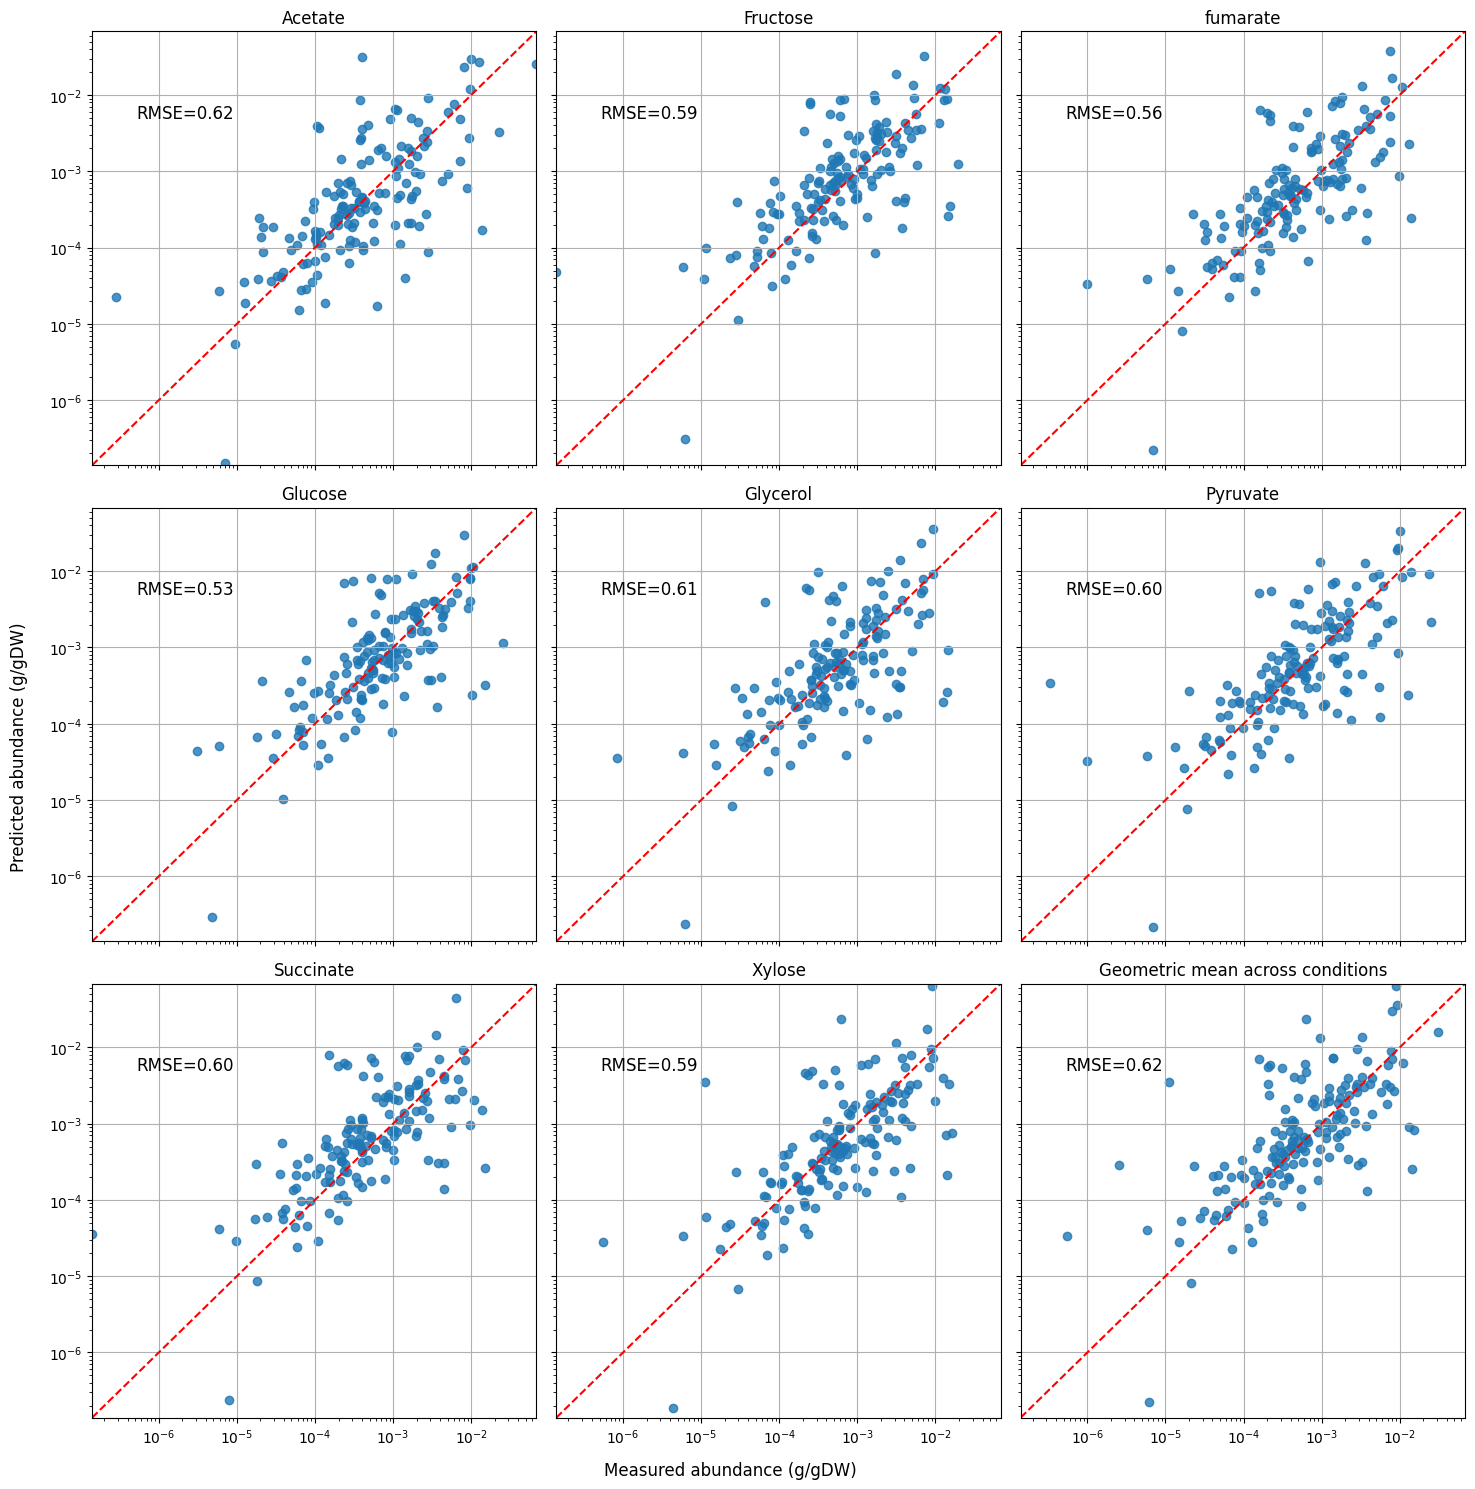

In [5]:
all_carbon_sources=results['enzyme_allocation']['carbon_source'].unique()
N=len(all_carbon_sources)+1
fig,ax=plt.subplots(3,3,figsize=(15,15),sharex=True,sharey=True)

shared_limits=[min(np.min(results['enzyme_allocation']['measured'][results['enzyme_allocation']['measured']>0]),
                   np.min(results['enzyme_allocation']['unadjusted_predicted'][results['enzyme_allocation']['unadjusted_predicted']>0])),
               max(np.max(results['enzyme_allocation']['measured'][results['enzyme_allocation']['measured']>0]),
                   np.max(results['enzyme_allocation']['unadjusted_predicted'][results['enzyme_allocation']['unadjusted_predicted']>0]))]

k=0
for i in range(3):
    for j in range(3):
        if k<len(all_carbon_sources):
            carbon_source=all_carbon_sources[k]
            cur_data=results['enzyme_allocation'].query("carbon_source==@carbon_source")
            ax[i,j].scatter(cur_data['measured'],cur_data['unadjusted_predicted'],alpha=0.8)
            ax[i,j].set_xscale("log")
            ax[i,j].set_yscale("log")
            ax[i,j].set_xlim(shared_limits)
            ax[i,j].set_ylim(shared_limits)
            ax[i,j].plot(shared_limits,shared_limits,'r--')
            ax[i,j].grid()

            #Styling
            ax[i,j].set_title(f"{carbon_sources_bigg2name_map[carbon_source]}",fontsize=label_fs)
            ax[i,j].text(0.1,0.8,f'RMSE={RMSEL(cur_data["measured"].values,cur_data["unadjusted_predicted"].values):.2f}',
                                        transform=ax[i,j].transAxes,fontsize=label_fs)
            k+=1

#Last plot, we plot geometric mean across conditions
GM=results['enzyme_allocation'].query("measured>0 & unadjusted_predicted>0").groupby("enzyme").aggregate(
                                                            {'unadjusted_predicted':geometric_mean,
                                                                'measured':geometric_mean}
                                                                )
ax[-1,-1].scatter(GM['measured'],GM['unadjusted_predicted'],alpha=0.8)
ax[-1,-1].set_xscale("log")
ax[-1,-1].set_yscale("log")
ax[-1,-1].set_xlim(shared_limits)
ax[-1,-1].set_ylim(shared_limits)
ax[-1,-1].plot(shared_limits,shared_limits,'r--')
ax[-1,-1].grid()
ax[-1,-1].set_title(f"Geometric mean across conditions",fontsize=label_fs)
ax[-1,-1].text(0.1,0.8,f'RMSE={RMSEL(GM["measured"].values,GM["unadjusted_predicted"].values):.2f}',
                            transform=ax[i,j].transAxes,fontsize=label_fs)


fig.supxlabel("Measured abundance (g/gDW)",fontsize=label_fs)
fig.supylabel("Predicted abundance (g/gDW) \n",fontsize=label_fs)
plt.tight_layout()
fig.savefig('../figures/unadjusted_kcats_enzyme_allocation_predictions.pdf',dpi=300,bbox_inches='tight')

# Enzyme allocation Predictions with fitted kcats

Note: a total of 317 data points, i.e. 20.89650626235992%% of total data points, are omitted from the left plot as they are predicted 0-abundance (due to 0-flux) in the EC-FBA solution
Note: a total of 26 data points are omitted from the right plot as they are predicted 0-abundance (due to 0-flux) in the EC-FBA solution


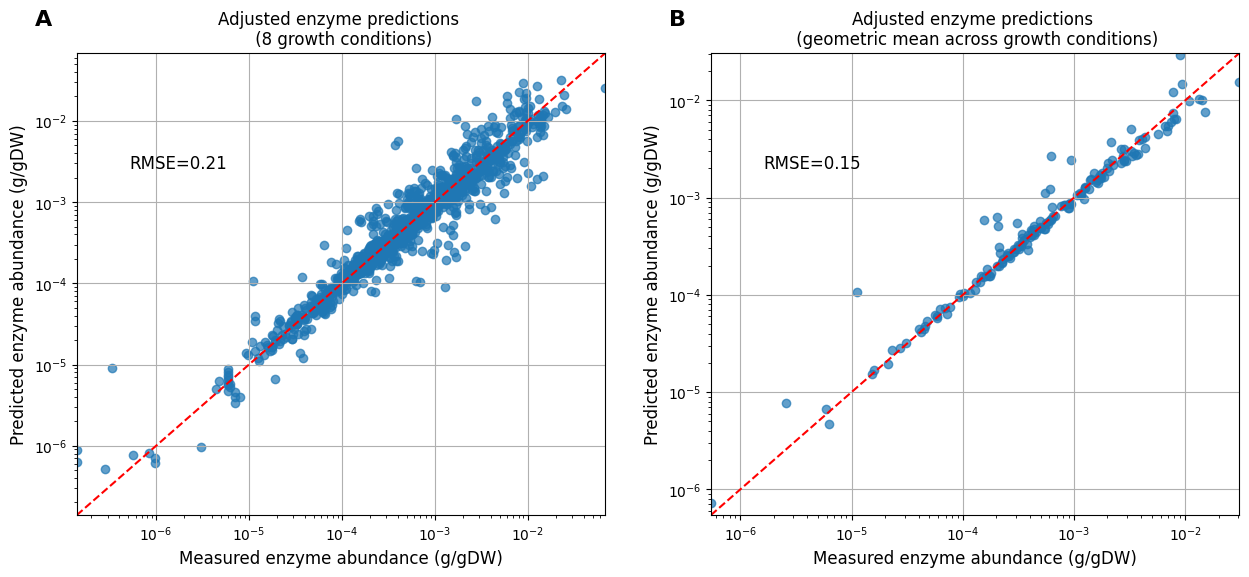

In [6]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
#Parameters
label_fs=12
title_fs=12


#Panel B
ax[0].scatter(results['enzyme_allocation']['measured'],
              results['enzyme_allocation']['adjusted_predicted'],
              alpha=0.7
              )
ax[0].set_xlabel('Measured enzyme abundance (g/gDW)',fontsize=label_fs)
ax[0].set_ylabel('Predicted enzyme abundance (g/gDW)',fontsize=label_fs)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
#Se0 common limits
shared_limits=[min(np.min(results['enzyme_allocation']['measured'][results['enzyme_allocation']['measured']>0]),
                   np.min(results['enzyme_allocation']['adjusted_predicted'][results['enzyme_allocation']['adjusted_predicted']>0])),
               max(np.max(results['enzyme_allocation']['measured'][results['enzyme_allocation']['measured']>0]),
                   np.max(results['enzyme_allocation']['adjusted_predicted'][results['enzyme_allocation']['adjusted_predicted']>0]))]
ax[0].set_xlim(shared_limits)
ax[0].set_ylim(shared_limits)
#Draw diagonal line
ax[0].plot(shared_limits,shared_limits,'r--')
ax[0].grid()
#write RMSEL on the top left of the plot
ax[0].text(0.1,0.75,f'RMSE={RMSEL(results["enzyme_allocation"]["measured"].values,results["enzyme_allocation"]["adjusted_predicted"].values):.2f}',
            transform=ax[0].transAxes,fontsize=label_fs)
#Add letter A to the plot
ax[0].set_title(f"Adjusted enzyme predictions \n ({len(results['enzyme_allocation']['carbon_source'].unique())} growth conditions)",fontsize=title_fs)
ax[0].text(-0.08, 1.06, 'A', transform=ax[0].transAxes, 
            size=16, weight='bold')

missed_predictions=results['enzyme_allocation'].query("adjusted_predicted==0 & measured>0")
print(f"Note: a total of {len(missed_predictions)} data points, i.e. {100*len(missed_predictions)/len(results['enzyme_allocation'])}%% of total data points, are omitted from the left plot as they are predicted 0-abundance (due to 0-flux) in the EC-FBA solution")
#Panel C.
#compute geometric mean of measured and predicted enzyme abundances
GM=results['enzyme_allocation'].query("measured>0 & adjusted_predicted>0").groupby("enzyme").aggregate(
                                                            {'adjusted_predicted':geometric_mean,
                                                                'measured':geometric_mean}
                                                                )
ax[1].scatter(GM['measured'],
                GM['adjusted_predicted'],
                alpha=0.7
                )
ax[1].set_xlabel('Measured enzyme abundance (g/gDW)',fontsize=label_fs)
ax[1].set_ylabel('Predicted enzyme abundance (g/gDW)',fontsize=label_fs)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
#Set common limits
shared_limits=[min(np.min(GM['measured'][GM['measured']>0]),
                   np.min(GM['adjusted_predicted'][GM['adjusted_predicted']>0])),
               max(np.max(GM['measured'][GM['measured']>0]),
                   np.max(GM['adjusted_predicted'][GM['adjusted_predicted']>0]))]
ax[1].set_xlim(shared_limits)
ax[1].set_ylim(shared_limits)
#Draw diagonal line
ax[1].plot(shared_limits,shared_limits,'r--')
ax[1].grid()
#Write RMSEL on the top left of the plot
ax[1].text(0.1,0.75,f'RMSE={RMSEL(GM["measured"].values,GM["adjusted_predicted"].values):.2f}',
            transform=ax[1].transAxes,fontsize=label_fs)

#Add letter C to the plot
ax[1].set_title(f'Adjusted enzyme predictions \n (geometric mean across growth conditions)',fontsize=title_fs)
ax[1].text(-0.08, 1.06, 'B', transform=ax[1].transAxes, 
            size=16, weight='bold')

zero_predictions_for_all_conditions=results['enzyme_allocation'].groupby("enzyme").aggregate({'adjusted_predicted':lambda x: np.all(x==0)}).query("adjusted_predicted==True")
print(f"Note: a total of {len(zero_predictions_for_all_conditions)} data points are omitted from the right plot as they are predicted 0-abundance (due to 0-flux) in the EC-FBA solution")
#save figure to file
fig.savefig('../figures/kcat_adjusted_enzyme_allocation_predictions.svg',dpi=300,bbox_inches='tight')
fig.savefig('../figures/kcat_adjusted_enzyme_allocation_predictions.pdf',dpi=300,bbox_inches='tight')

Mean absolute log10(kcat) deviation: 0.21


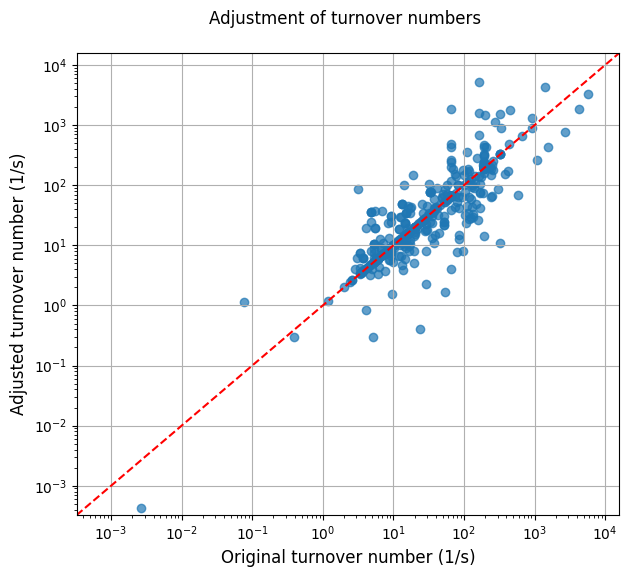

In [7]:
fig,ax=plt.subplots(1,1,figsize=(7,6))
ax=[ax]
#Panel A
ax[0].scatter(results['kcats']['original_kcats'],
              results['kcats']['adjusted_kcats'],
              alpha=0.7
              )
ax[0].set_xlabel('Original turnover number (1/s)',fontsize=label_fs)
ax[0].set_ylabel('Adjusted turnover number (1/s)',fontsize=label_fs)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
#Set common limits
shared_limits=[min(np.min(results['kcats']['original_kcats'][results['kcats']['original_kcats']>0]),
                   np.min(results['kcats']['adjusted_kcats'][results['kcats']['adjusted_kcats']>0]))-0.0001,
               max(np.max(results['kcats']['original_kcats'][results['kcats']['original_kcats']>0]),
                   np.max(results['kcats']['adjusted_kcats'][results['kcats']['adjusted_kcats']>0]))+10000]
ax[0].set_xlim(shared_limits)
ax[0].set_ylim(shared_limits)
#Draw diagonal line
ax[0].plot(shared_limits,shared_limits,'r--')
ax[0].grid()
#Add letter A to the plot
ax[0].set_title(f'Adjustment of turnover numbers \n',fontsize=title_fs)

fig.savefig('../../manuscript_figures/figures/original_vs_adjusted_kcats.pdf',dpi=300,bbox_inches='tight')

print(f"Mean absolute log10(kcat) deviation: {np.mean(np.abs(np.log10(results['kcats']['original_kcats'])-np.log10(results['kcats']['adjusted_kcats']))):.2f}")

# Deviation of fitted kcats from the original dataset

Mean absolute log10(kcat) deviation: 0.21


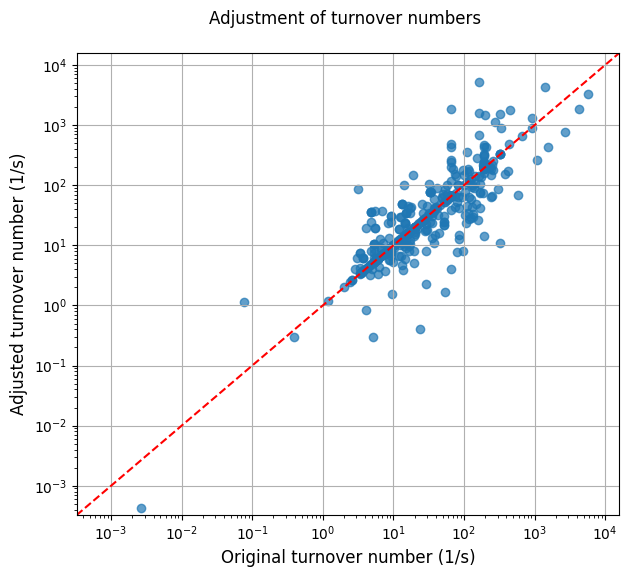

In [8]:
fig,ax=plt.subplots(1,1,figsize=(7,6))
ax=[ax]
#Panel A
ax[0].scatter(results['kcats']['original_kcats'],
              results['kcats']['adjusted_kcats'],
              alpha=0.7
              )
ax[0].set_xlabel('Original turnover number (1/s)',fontsize=label_fs)
ax[0].set_ylabel('Adjusted turnover number (1/s)',fontsize=label_fs)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
#Set common limits
shared_limits=[min(np.min(results['kcats']['original_kcats'][results['kcats']['original_kcats']>0]),
                   np.min(results['kcats']['adjusted_kcats'][results['kcats']['adjusted_kcats']>0]))-0.0001,
               max(np.max(results['kcats']['original_kcats'][results['kcats']['original_kcats']>0]),
                   np.max(results['kcats']['adjusted_kcats'][results['kcats']['adjusted_kcats']>0]))+10000]
ax[0].set_xlim(shared_limits)
ax[0].set_ylim(shared_limits)
#Draw diagonal line
ax[0].plot(shared_limits,shared_limits,'r--')
ax[0].grid()
#Add letter A to the plot
ax[0].set_title(f'Adjustment of turnover numbers \n',fontsize=title_fs)

fig.savefig('../figures/original_vs_adjusted_kcats.pdf',dpi=300,bbox_inches='tight')

print(f"Mean absolute log10(kcat) deviation: {np.mean(np.abs(np.log10(results['kcats']['original_kcats'])-np.log10(results['kcats']['adjusted_kcats']))):.2f}")

# Effect of the choice of regularisation coefficient

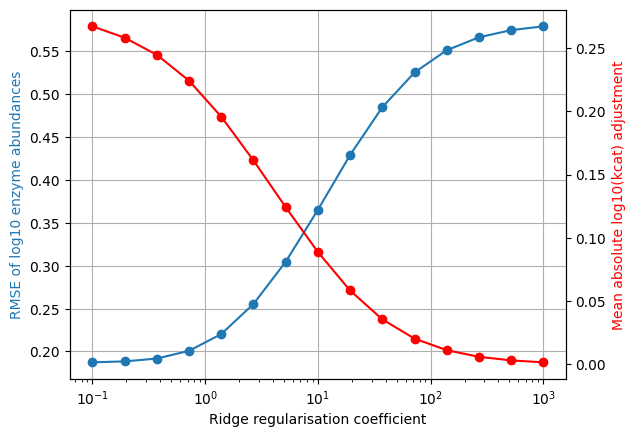

In [9]:
rho_ar=results['regularisation_coefficient_sweep']['rho_ar']
results_ar=results['regularisation_coefficient_sweep']['results_ar']
fig,ax=plt.subplots()
RMSEL_vs_lam=[]
kcat_MAEL=[]
for res in results_ar:
    cur_RMSEL=RMSEL(x=res['enzyme_allocation']['adjusted_predicted'].values,
                    y=res['enzyme_allocation']['measured'].values)
    cur_mean_log_kcat_deviation=np.mean(np.abs(np.log10(res['kcats']['original_kcats'])-np.log10(res['kcats']['adjusted_kcats'])))
    kcat_MAEL.append(cur_mean_log_kcat_deviation)
    RMSEL_vs_lam.append(cur_RMSEL)

ax.plot(rho_ar,RMSEL_vs_lam,'-o')
ax.set_xlabel("Ridge regularisation coefficient")
ax.set_ylabel("RMSE of log10 enzyme abundances",color='tab:blue')
#ax.set_yscale('log')
ax.set_xscale('log')

ax_kcat=ax.twinx()
ax_kcat.plot(rho_ar,kcat_MAEL,'-o',color='red')
ax_kcat.set_ylabel("Mean absolute log10(kcat) adjustment",color='red')
ax.grid()

fig.savefig('../figures/regularisation_parameter_sweep.pdf',dpi=300,bbox_inches='tight')